In [1]:
using Revise
using LinearAlgebra
using Statistics
using YAML
using JLD2
includet("utils.jl")
config_dict = YAML.load_file("../experiment_config.yml");

In [4]:
# println(pwd())
# include("../observation_map.jl")
# # config_dict = YAML.load_file("experiment_config.yml")
# tmat = observation_map(0)

In [9]:
eki = JLD2.load_object("../output/local_calibration/iteration_009/eki_file.jld2")
prior = CAL.get_prior("../prior.toml")
# EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))[1]

ParameterDistribution with 5 entries: 
'mixing_length_eddy_viscosity_coefficient' with EnsembleKalmanProcesses.ParameterDistributions.Constraint{EnsembleKalmanProcesses.ParameterDistributions.BoundedBelow}[Bounds: (0.0, ∞)] over distribution EnsembleKalmanProcesses.ParameterDistributions.Parameterized(Distributions.Normal{Float64}(μ=-1.798899386179365, σ=0.23213161890397324)) 
'detr_massflux_vertdiv_coeff' with EnsembleKalmanProcesses.ParameterDistributions.Constraint{EnsembleKalmanProcesses.ParameterDistributions.BoundedBelow}[Bounds: (0.0, ∞)] over distribution EnsembleKalmanProcesses.ParameterDistributions.Parameterized(Distributions.Normal{Float64}(μ=0.13599544622138604, σ=0.0867928125339026)) 
'entr_coeff' with EnsembleKalmanProcesses.ParameterDistributions.Constraint{EnsembleKalmanProcesses.ParameterDistributions.BoundedBelow}[Bounds: (0.0, ∞)] over distribution EnsembleKalmanProcesses.ParameterDistributions.Parameterized(Distributions.Normal{Float64}(μ=-1.1471863764563475, σ=0.1

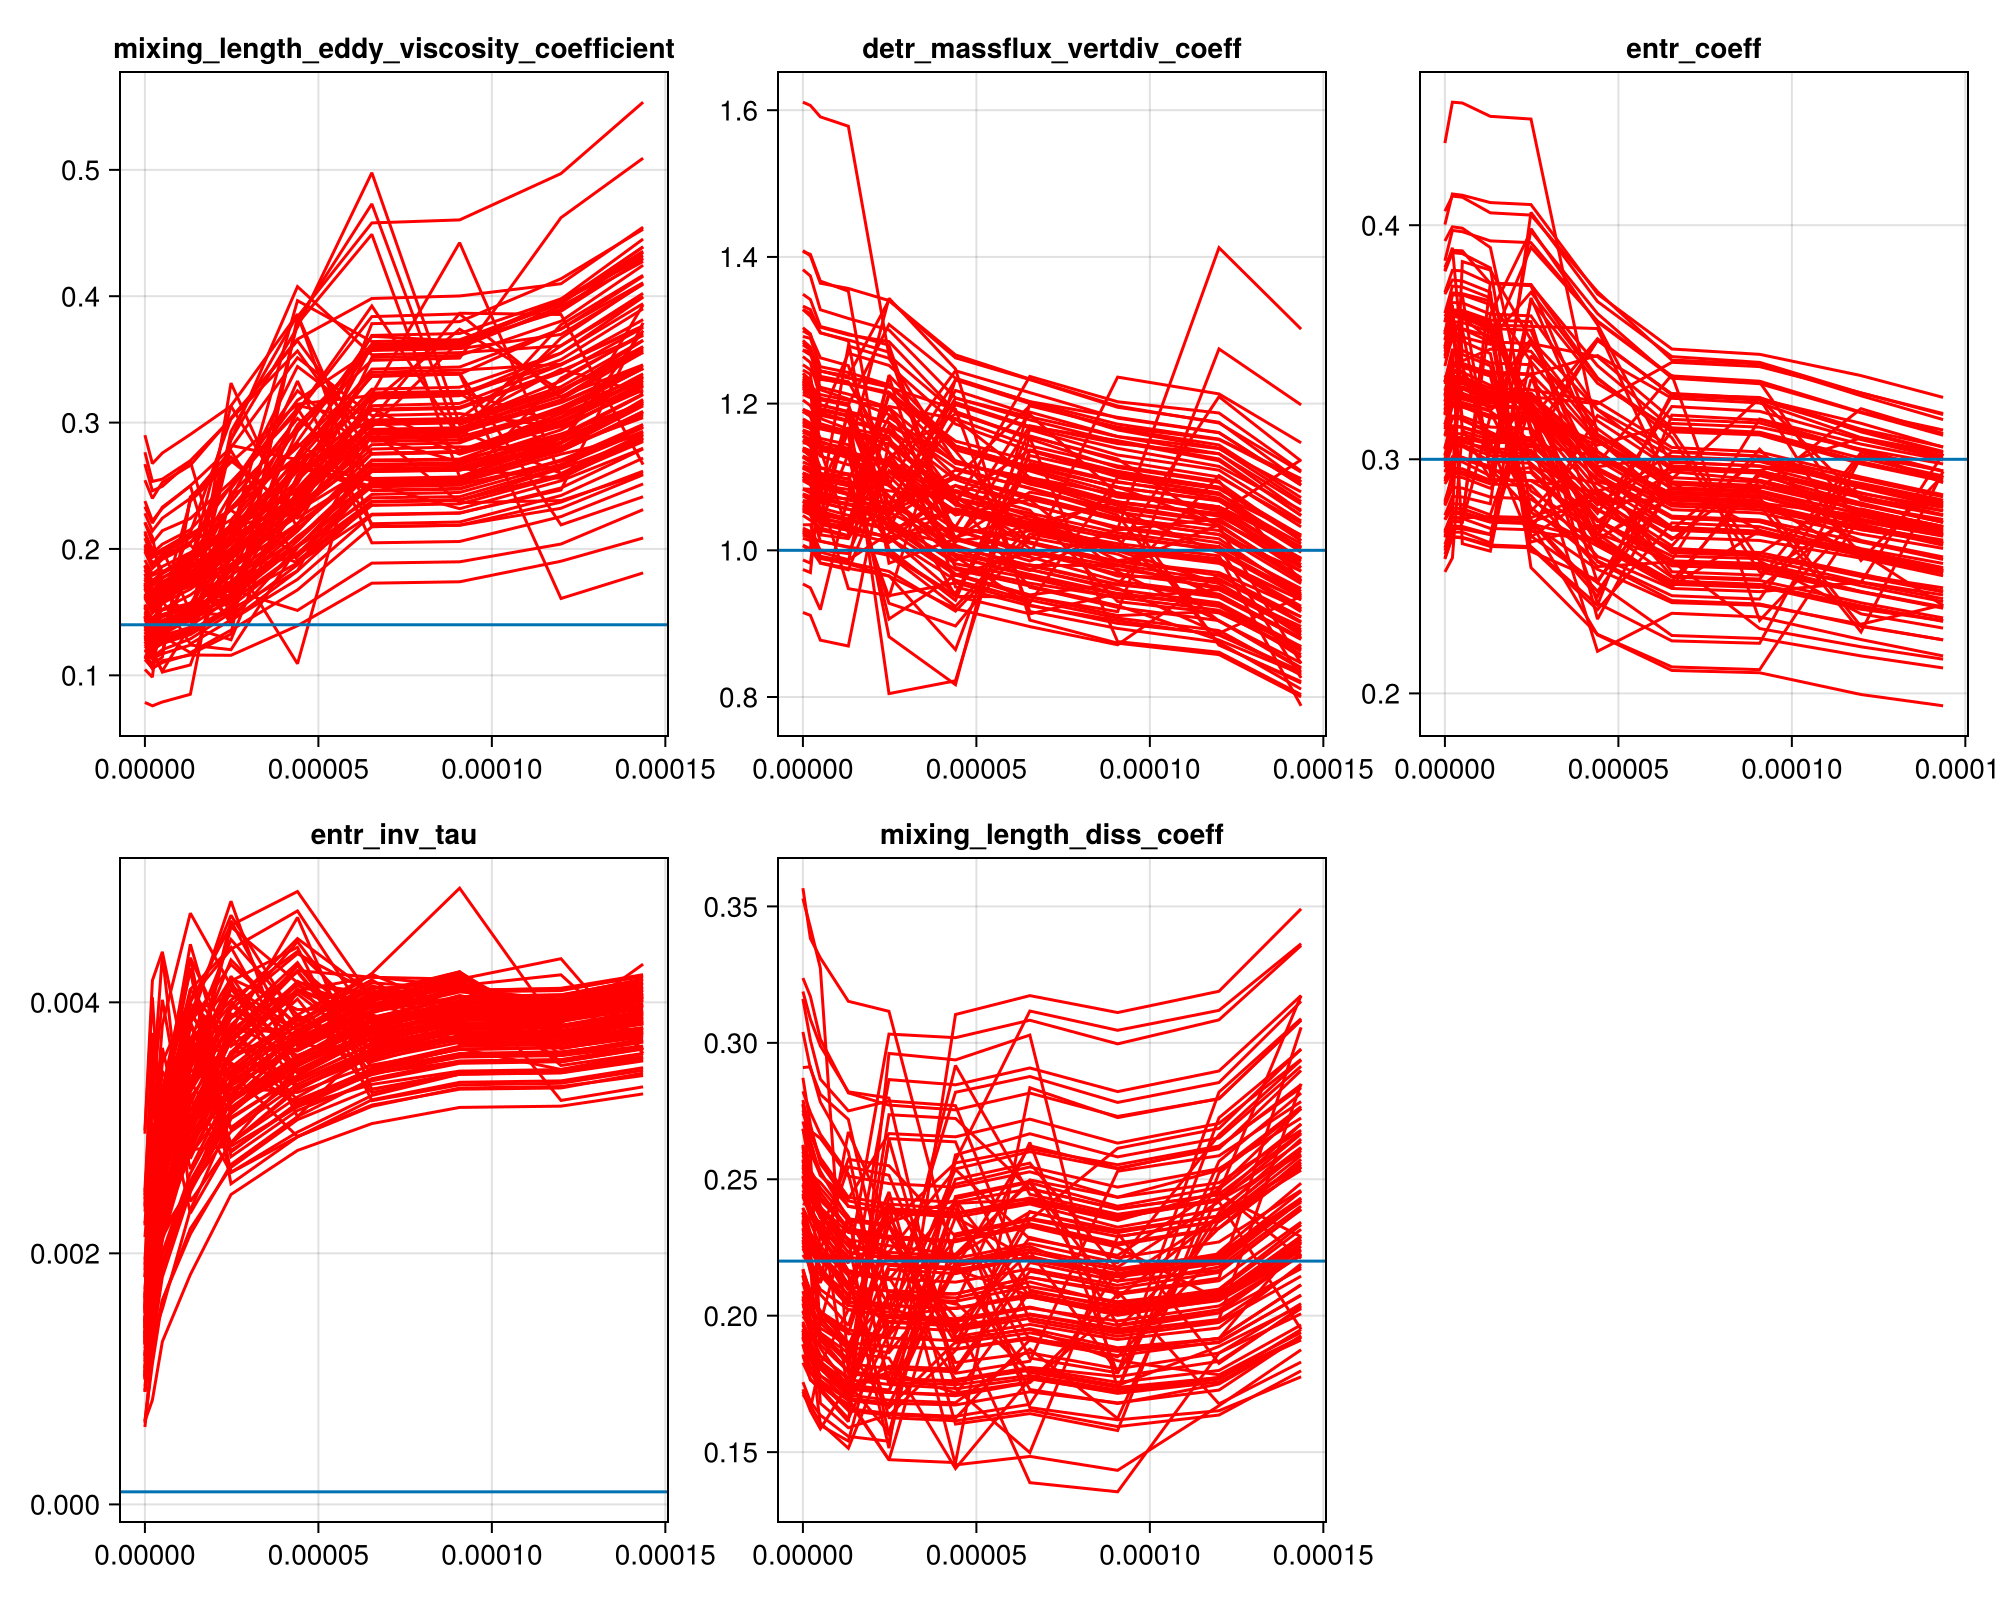

In [73]:
phi = cat(EKP.get_ϕ(prior, eki)..., dims = 3)
time = vcat(0, cumsum(eki.Δt))
fig = Figure(size = (1000, 800))
num_per_row = 3
for (i, name) in enumerate(EKP.get_name(prior))
    row = div(i-1, num_per_row) + 1
    col = mod(i-1, num_per_row) + 1
    ax = Axis(fig[row, col], title = name)
    for ens in 1:100
        lines!(ax, time, phi[i, ens, :], color= :red)
    end
    hlines!(ax, params_true[i])
end
fig

In [4]:
# functionalize the 
iteration =9
output_dir = joinpath("../output", "local_calibration")
eki_filepath = joinpath(CAL.path_to_iteration(output_dir, iteration), "eki_file.jld2")
eki = JLD2.load_object(eki_filepath)
loss_vals = EKP.get_g(eki);

In [3]:
observations = JLD2.load_object("../observations.jld2")
obs_var = JLD2.load_object("../obs_noise_cov.jld2")
variances = diag(obs_var);

In [7]:
variances

9-element Vector{Float64}:
   0.1
 100.0
   1.0e7
   3.0
   0.03
   1.0
   1.0
   1.0
   1.0

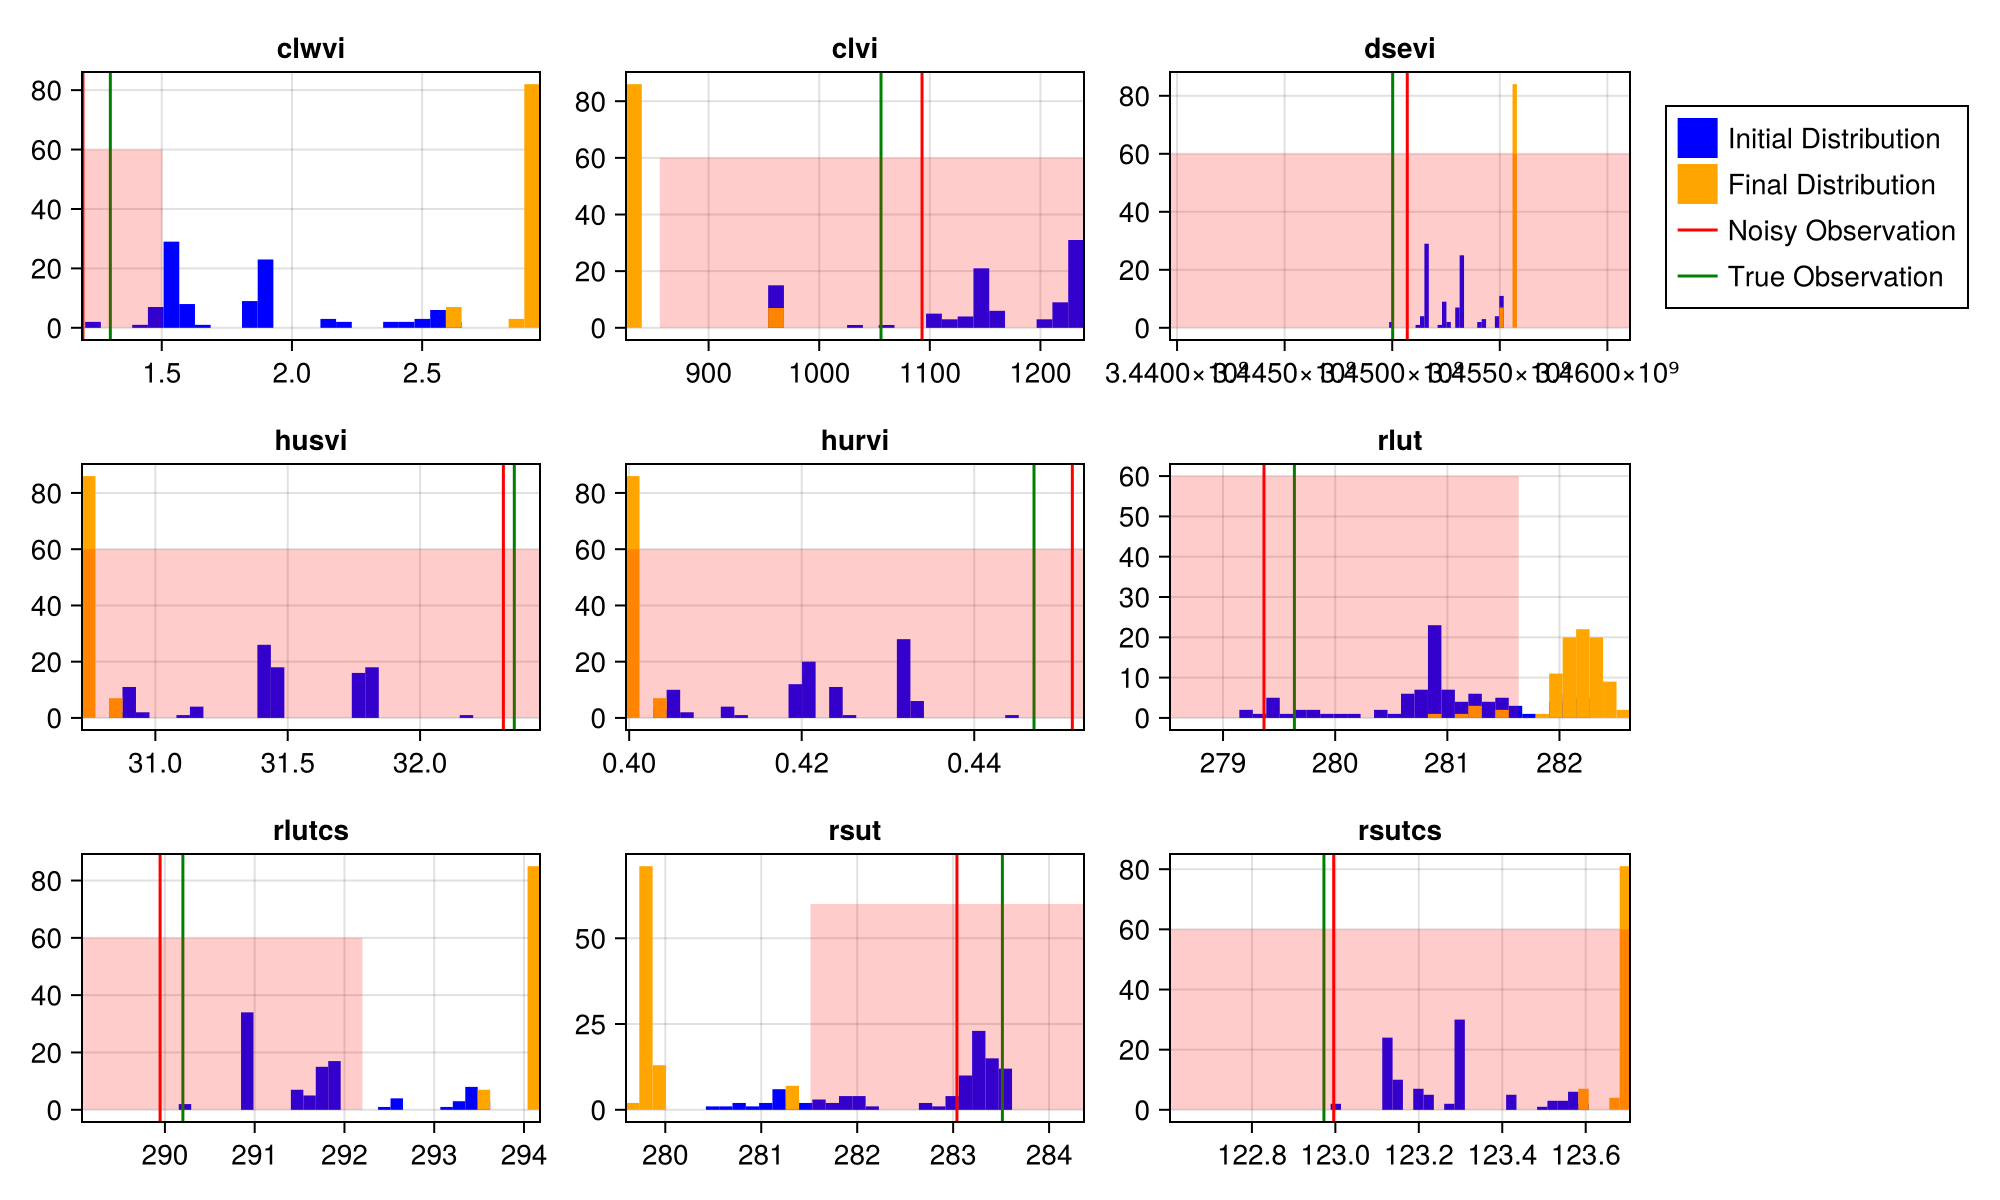

In [75]:
# plot histograms of simulations
fig = Figure(size = (1000, 600))
num_per_row = 3
for i in 1:9
    row = div(i-1, num_per_row) + 1
    col = mod(i-1, num_per_row) + 1

    # get data 
    prior_dist = loss_vals[1][i, :]
    end_dist = filter(!isnan, loss_vals[end][i, :])
    gmin = minimum(vcat(prior_dist, end_dist))
    gmax = maximum(vcat(prior_dist, end_dist))
    bins = range(gmin, gmax, length = 30)

    # get perfect simulation data
    obs = small_noise_obs[i]
    vari = variances[i]#sqrt(rel_cov10[i])
    
    ax = Axis(fig[row, col], title = config_dict["y_var_names"][i],
        limits = ((minimum([gmin, obs*.997, true_obs[i]*.997]), maximum([gmax, obs*1.003, true_obs[i]*1.003])), nothing))
    

    hist!(ax, prior_dist, bins = bins, color = :blue, label = "Initial Distribution")
    hist!(ax, end_dist, bins = bins, color = :orange, label = "Final Distribution")


    vlines!(ax, obs, color=:red, label = "Noisy Observation")
    vlines!(ax, true_obs[i], color="green", label = "True Observation")

    # shade polygon for 2x standard deviations 

    n_vari = 2
    poly!(ax, [true_obs[i]-n_vari*vari, true_obs[i]+n_vari*vari, true_obs[i] + n_vari*vari, true_obs[i] - n_vari*vari] ,
                [0, 0, 60, 60],
                color=(:red, .2))
    if i == 1
        legend = Legend(fig, ax, orientation = :vertical, tellheight = false)
        fig[1, num_per_row + 1] = legend
    end
end


fig


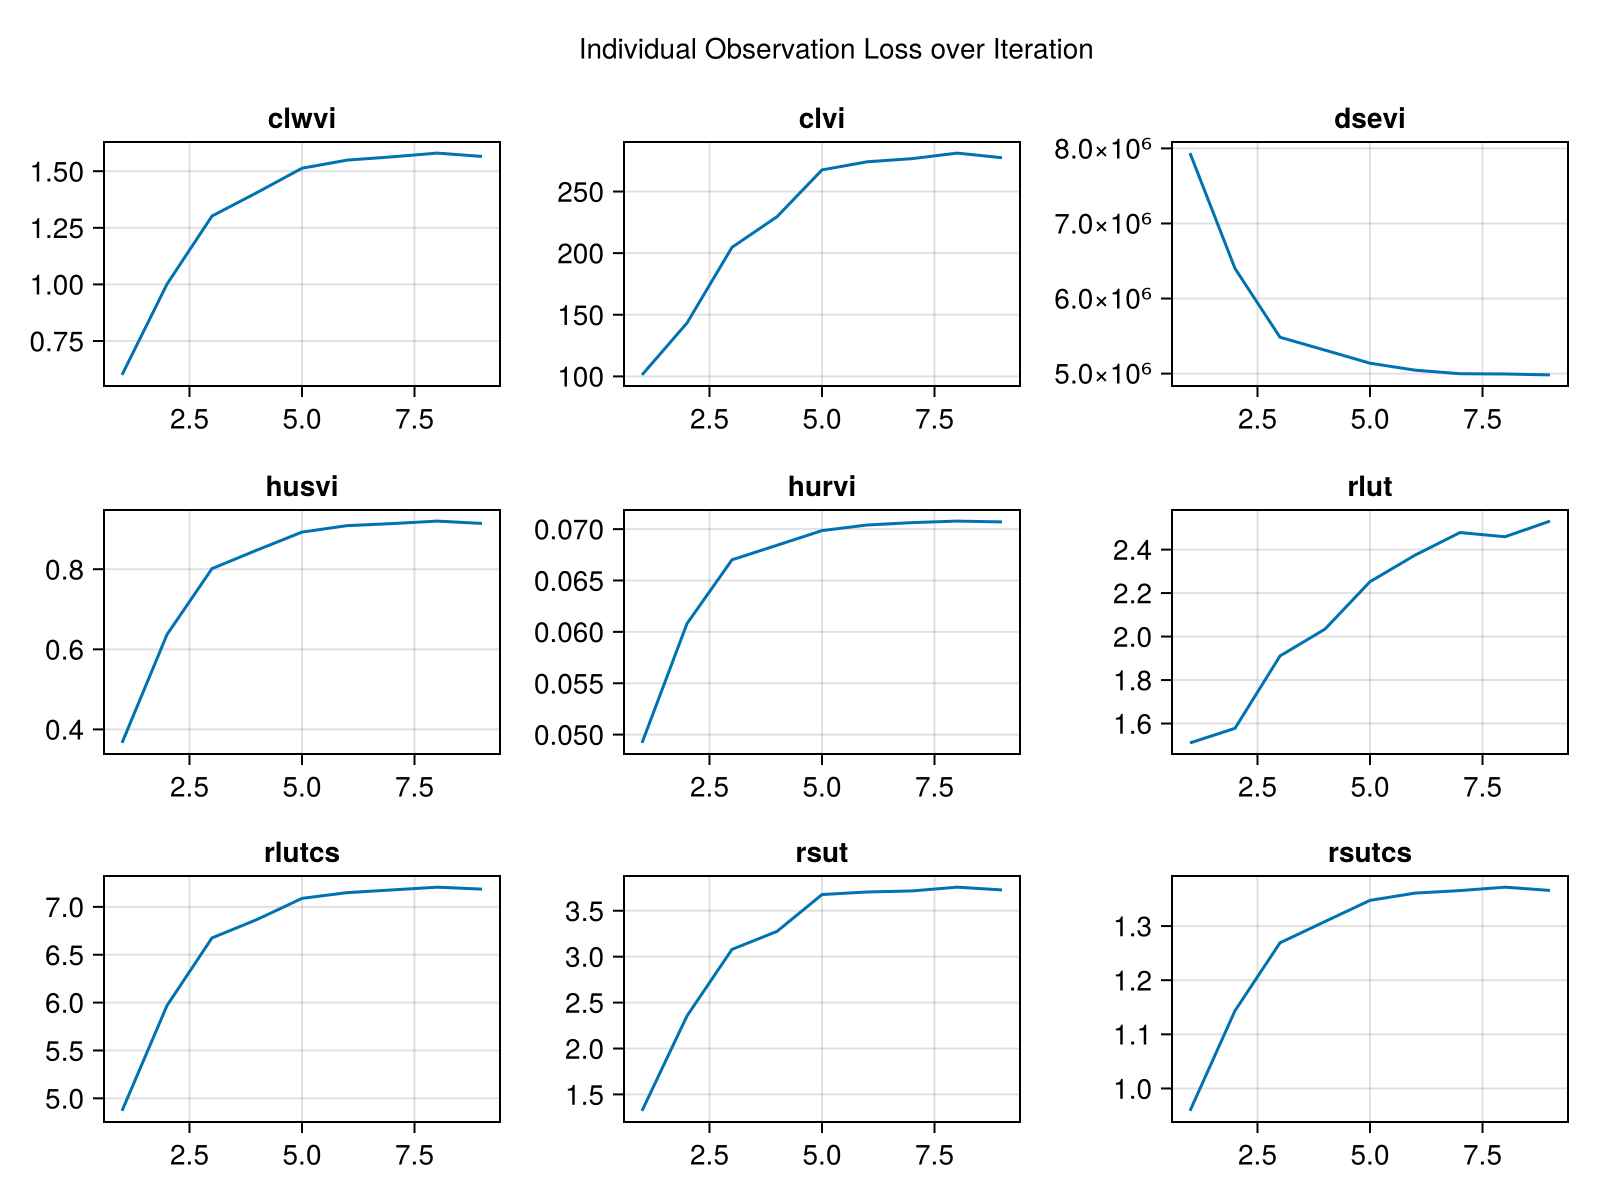

In [26]:
all_loss = []
for iteration in 1:9
    vals = []
        for metric in 1:9
            vmean = mean(filter(!isnan, ((loss_vals[iteration] .- observations) .^2)[metric,:]))
            append!(vals, sqrt(vmean))
        end
    append!(all_loss, [vals])
    end
all_loss
    
fig = Figure(size = (800, 600))
num_per_row = 3
for metric in 1:9
    row = div(metric-1, num_per_row) + 1
    col = mod(metric-1, num_per_row) + 1
    vals = []
    for iteration in 1:9
        append!(vals, all_loss[iteration][metric])
    end
    ax = Axis(fig[row, col], title = config_dict["y_var_names"][metric])
    lines!(ax, vals)
end
Label(fig[0,:], "Individual Observation Loss over Iteration")
fig

In [35]:
using ClimaAnalysis
function gen_obs(simdir = "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_0003")
    simdir = SimDir(simdir)
    process_member_data(simdir; y_names = config_dict["y_var_names"], t_start = config_dict["g_t_start_sec"], t_end = config_dict["g_t_end_sec"])
end
true_obs2 = gen_obs()
#JLD2.save_object("../observations.jld2", observations)

9-element Vector{Float64}:
    1.2989342212677002
 1055.1180419921875
    3.44999936e9
   32.34925079345703
    0.44690820574760437
  279.61328125
  290.1968994140625
  283.4769592285156
  122.9736557006836

In [36]:
true_obs2-true_obs

9-element Vector{Float64}:
     -0.0035915374755859375
     -0.754638671875
 -22016.0
     -0.006587982177734375
     -2.104043960571289e-5
     -0.02301025390625
     -0.003326416015625
     -0.03619384765625
      0.001068115234375

In [30]:
#obs_vars = [.3, .036, .00042, 5, 5e-5, 1, 1, 1, 1]
readdir("../../")
#JLD2.save_object("../obs_noise_cov.jld2", Diagonal(obs_vars))

5-element Vector{String}:
 "gcm_driven_scm"
 "local_calibration"
 "perf_gcm_driven_scm"
 "prognostic_edmfx_bomex"
 "sphere_held_suarez_rhoe_equilmoist"

In [96]:
# load observations 
obs = JLD2.load_object("../observations.jld2")
obs_cov = JLD2.load_object("../obs_noise_cov.jld2")

9×9 Diagonal{Float64, Vector{Float64}}:
 0.0863326   ⋅        ⋅           ⋅       …   ⋅           ⋅        ⋅ 
  ⋅         1.23893   ⋅           ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅       7.18732e-7   ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅          2.92695      ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅       …   ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅          0.00360234   ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅          4.13139   ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅           ⋅       2.74378

In [39]:
# make observational_covariance matrix based on prior distribution width
relative_obs_covs = []
for i in 1:9
    prior_dist = loss_vals[1][i, :]
    append!(relative_obs_covs, maximum(prior_dist) - minimum(prior_dist))
end

In [70]:
rel_std10 = (relative_obs_covs * .1)

9-element Vector{Float64}:
      0.1427883744239807
     27.900421142578125
 528256.0
      0.1346067428588867
      0.004112312197685242
      0.30682373046875
      0.3365234375
      0.30981140136718754
      0.060914611816406256

In [74]:
rand_vals = randn(9)
println(rand_vals)
small_noise_obs = true_obs .+ rand_vals .* rel_std10;

[-0.7370113574849282, 1.3293963357269525, 1.2837153615331018, -0.30675560739318325, 1.0797194849014025, -0.8838800845740474, -0.7548282516868406, -1.5291457618952906, 0.3848367440457666]


In [66]:
pwd()

"/central/home/jschmitt/ClimaAtmos.jl/calibration/experiments/local_calibration/post_processing"

In [76]:
# save it
JLD2.save_object("../observations.jld2", small_noise_obs)

In [83]:
# let's not use correlated noise just yet
# using Random, Distributions 

# sample_cov_matrix = cov(transpose(loss_vals[1]))
# mean_vec = zeros(9)
# mv_normal = MvNormal(mean_vec, sample_cov_matrix)

# rand_vector_cov = rand(mv_normal)

9-element Vector{Float64}:
     -0.006393766512050513
     -2.3233903150854975
 -23098.661866868963
     -0.04147076533531246
     -0.000350807937148303
     -0.6926048419318191
      0.0533250395592364
     -0.29924522726101177
      0.006786906856710985